# ЭТАП 4. СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ.

В этой части мы обучим модели 3 различных архитектур: логистическая регрессия, случайный лес, многослойный перцептрон.
    
Все модели будем обучать на выборке с top-10 признаков и с помощью кросс-валидации

<AxesSubplot:>

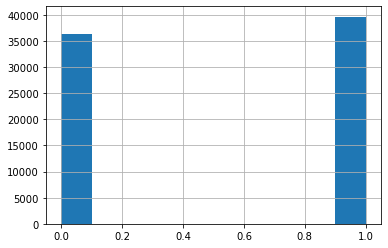

In [1]:
import pandas as pd, dill
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from copy import deepcopy

#загрузим данные, полученные на этапе 2
data_train = pd.read_csv('data_train_all.csv')
data_test = pd.read_csv('data_test_all.csv')

#приведем тип услуги к dummy-виду:
vas_id_train = pd.get_dummies(data_train.vas_id)
vas_id_test = pd.get_dummies(data_test.vas_id)

#добавляем dummy-данные о типах предложений в выборки
data_train = data_train[list(data_train.columns)[3:]]
data_train = pd.concat((data_train,vas_id_train),axis=1)

data_test = data_test[list(data_test.columns)[3:]]
data_test = pd.concat((data_test,vas_id_test),axis=1)

#"раздуем" выборку для достижения сбалансированности между классами
data_train_1 = data_train.loc[data_train.target==1]
for i in range(14):
    data_train = pd.concat((data_train,data_train_1),axis=0)

#загрузим наши top-10 признаков:
with open('top_10.dat','rb') as f:
    f_top_10 = dill.load(f)

data_train.target.hist()

In [2]:
#Перемешаем выборку, разделим входные векторы и образцы:
data_train = data_train.sample(frac=1.0, ignore_index=True)

X_v1 = data_train[f_top_10]
y_v1 = data_train.target
print(X_v1.shape, y_v1.shape)

(75903, 10) (75903,)


## 4.1. Создание моделей лог. регрессии; обучение с помощью кросс-валидации

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

Работаем с моделями логистической регрессии.

Для моделей лог. регрессии будем варьировать 2 параметра: кол-во итераций и коэффициент C - обратная сила регуляризации. Метрика: F1-score(macro)

In [32]:
mas_C = [0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0] #значения коэффициента C
mas_iter = list(range(50,851,50)) #значения кол-ва итераций

log_reg_res_mea = np.zeros((len(mas_C),len(mas_iter))) #средние значения F1
log_reg_res = [[[] for j in range(len(mas_iter))] for i in range(len(mas_C))]
log_reg_roc_auc = [[[] for j in range(len(mas_iter))] for i in range(len(mas_C))]
log_reg_prec_rec = [[[] for j in range(len(mas_iter))] for i in range(len(mas_C))]
log_reg_mdls = [[[] for j in range(len(mas_iter))] for i in range(len(mas_C))]

In [33]:
for i in range(len(mas_C)):
    for j in range(len(mas_iter)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = LogisticRegression(penalty='l1', max_iter=mas_iter[j], C=mas_C[i], solver='liblinear')
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        log_reg_res[i][j] = res_prom
        log_reg_res_mea[i,j] = res_prom.mean()
        
        log_reg_roc_auc[i][j] = res_roc_auc
        log_reg_prec_rec[i][j] = res_prec_rec
        log_reg_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Значение C')

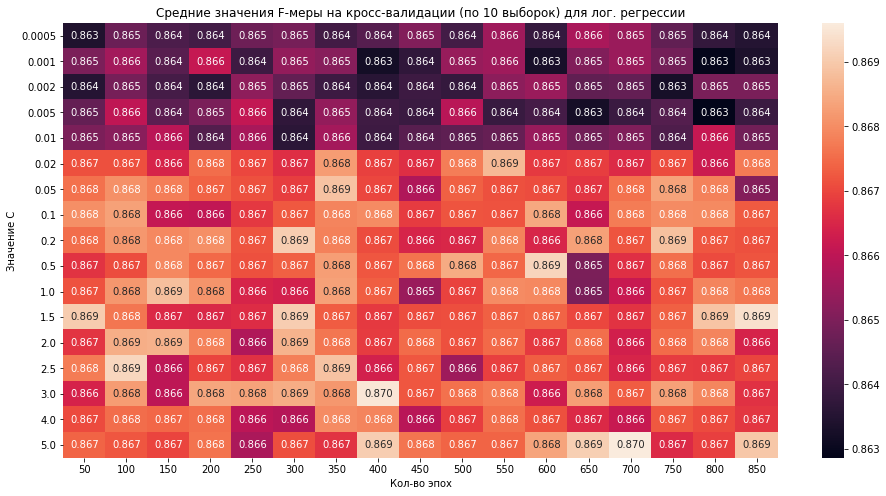

In [34]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(log_reg_res_mea, annot=log_reg_res_mea, fmt=".3f")
ax.set_xticklabels(mas_iter)
ax.set_yticklabels(mas_C, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для лог. регрессии')
ax.set_xlabel('Кол-во эпох')
ax.set_ylabel('Значение C')

Результаты различаются незначительно. Поэтому будем иметь в виду одну из моделей с параметрами C=3.0 и 400 эпохами обучения

## 4.2. Создание моделей случайного леса; обучение с помощью кросс-валидации

Теперь работаем с моделями случайного леса.

Для моделей случайного леса будем варьировать следующие 2 параметра: число деревьев и максимальную их глубину. Метрика: F1-score(macro)

In [35]:
mas_trees = [7,8,9,10,11,12,13,14] #значения кол-ва деревьев
mas_depth = [5,6,7,8,9,10,11,12] #значения макс. глубины

rand_for_res_mea = np.zeros((len(mas_trees),len(mas_depth))) #средние значения F1
rand_for_res = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_roc_auc = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_prec_rec = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_mdls = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]

In [36]:
for i in range(len(mas_trees)):
    for j in range(len(mas_depth)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = RandomForestClassifier(n_estimators=mas_trees[i], max_depth=mas_depth[j])
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        rand_for_res[i][j] = res_prom
        rand_for_res_mea[i,j] = res_prom.mean()
        
        rand_for_roc_auc[i][j] = res_roc_auc
        rand_for_prec_rec[i][j] = res_prec_rec
        rand_for_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Макс. кол-во деревьев')

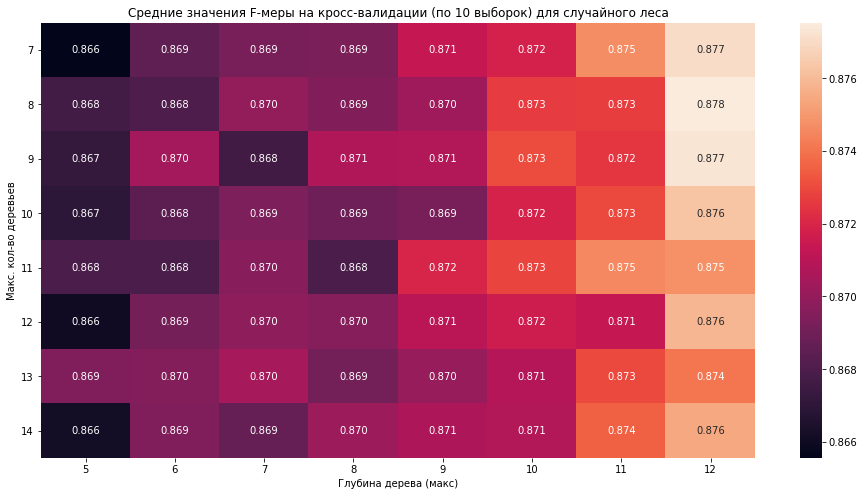

In [38]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(rand_for_res_mea, annot=rand_for_res_mea, fmt=".3f")
ax.set_xticklabels(mas_depth)
ax.set_yticklabels(mas_trees, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для случайного леса')
ax.set_xlabel('Глубина дерева (макс)')
ax.set_ylabel('Макс. кол-во деревьев')

Глубина дерева положительно влияет на результаты обучения. Повторим процесс обучения еще раз, увеличив глубину деревьев:

In [39]:
mas_trees = [7,8,9,10,11,12,13,14] #значения кол-ва деревьев
mas_depth = [12,13,14,15,16,17,18,20] #значения макс. глубины

rand_for_res_mea = np.zeros((len(mas_trees),len(mas_depth))) #средние значения F1
rand_for_res = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_roc_auc = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_prec_rec = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_mdls = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]

In [40]:
for i in range(len(mas_trees)):
    for j in range(len(mas_depth)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = RandomForestClassifier(n_estimators=mas_trees[i], max_depth=mas_depth[j])
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        rand_for_res[i][j] = res_prom
        rand_for_res_mea[i,j] = res_prom.mean()
        
        rand_for_roc_auc[i][j] = res_roc_auc
        rand_for_prec_rec[i][j] = res_prec_rec
        rand_for_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Макс. кол-во деревьев')

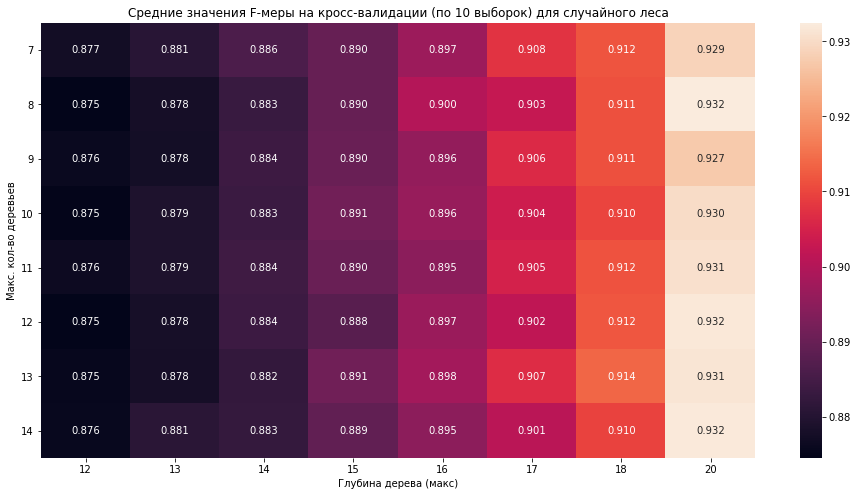

In [41]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(rand_for_res_mea, annot=rand_for_res_mea, fmt=".3f")
ax.set_xticklabels(mas_depth)
ax.set_yticklabels(mas_trees, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для случайного леса')
ax.set_xlabel('Глубина дерева (макс)')
ax.set_ylabel('Макс. кол-во деревьев')

Еще круче! Повторим процесс:

In [42]:
mas_trees = [7,8,9,10,11,12,13,14] #значения кол-ва деревьев
mas_depth = [20,21,22,23,24,25,26,28] #значения макс. глубины

rand_for_res_mea = np.zeros((len(mas_trees),len(mas_depth))) #средние значения F1
rand_for_res = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_roc_auc = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_prec_rec = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_mdls = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]

In [43]:
for i in range(len(mas_trees)):
    for j in range(len(mas_depth)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = RandomForestClassifier(n_estimators=mas_trees[i], max_depth=mas_depth[j])
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        rand_for_res[i][j] = res_prom
        rand_for_res_mea[i,j] = res_prom.mean()
        
        rand_for_roc_auc[i][j] = res_roc_auc
        rand_for_prec_rec[i][j] = res_prec_rec
        rand_for_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Макс. кол-во деревьев')

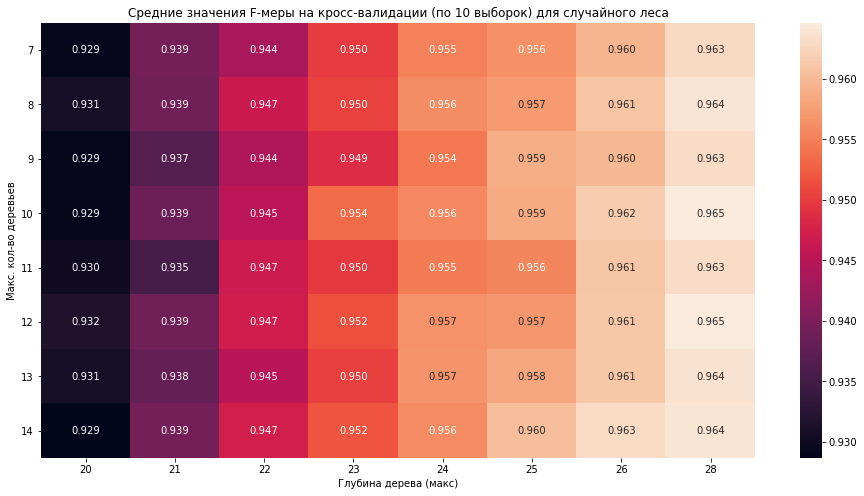

In [44]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(rand_for_res_mea, annot=rand_for_res_mea, fmt=".3f")
ax.set_xticklabels(mas_depth)
ax.set_yticklabels(mas_trees, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для случайного леса')
ax.set_xlabel('Глубина дерева (макс)')
ax.set_ylabel('Макс. кол-во деревьев')

SUPER BIG WIN! Повторим еще раз:

In [45]:
mas_trees = [7,8,9,10,11,12,13,14] #значения кол-ва деревьев
mas_depth = [28,29,30,32,34,35,36,38] #значения макс. глубины

rand_for_res_mea = np.zeros((len(mas_trees),len(mas_depth))) #средние значения F1
rand_for_res = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_roc_auc = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_prec_rec = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_mdls = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]

In [46]:
for i in range(len(mas_trees)):
    for j in range(len(mas_depth)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = RandomForestClassifier(n_estimators=mas_trees[i], max_depth=mas_depth[j])
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        rand_for_res[i][j] = res_prom
        rand_for_res_mea[i,j] = res_prom.mean()
        
        rand_for_roc_auc[i][j] = res_roc_auc
        rand_for_prec_rec[i][j] = res_prec_rec
        rand_for_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Макс. кол-во деревьев')

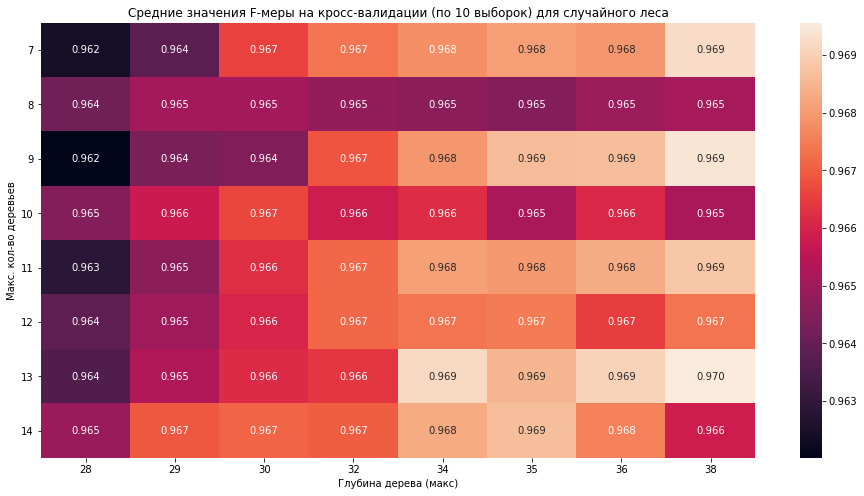

In [47]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(rand_for_res_mea, annot=rand_for_res_mea, fmt=".3f")
ax.set_xticklabels(mas_depth)
ax.set_yticklabels(mas_trees, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для случайного леса')
ax.set_xlabel('Глубина дерева (макс)')
ax.set_ylabel('Макс. кол-во деревьев')

Дальше улучшения по глубине дерева не наблюдается. Увеличим кол-во деревьев:

In [4]:
mas_trees = [13,14,15,16,18,20,22,24] #значения кол-ва деревьев
mas_depth = [28,29,30,32,34,35,36,38] #значения макс. глубины

rand_for_res_mea = np.zeros((len(mas_trees),len(mas_depth))) #средние значения F1
rand_for_res = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_roc_auc = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_prec_rec = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]
rand_for_mdls = [[[] for j in range(len(mas_depth))] for i in range(len(mas_trees))]

In [5]:
for i in range(len(mas_trees)):
    for j in range(len(mas_depth)):
        res_prom = [] #промежуточные оценки F1-score
        res_roc_auc = [] #значения roc-auc кривых
        res_prec_rec = [] #значения кривых precision-recall
        res_mdls = [] #модели
        
        for k in range(10): #ручная кросс-валидация
            X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
            model = RandomForestClassifier(n_estimators=mas_trees[i], max_depth=mas_depth[j])
            model.fit(X_v1_train,y_v1_train)
            
            y_pred = model.predict_proba(X_v1_test)
            y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
            res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
            res_roc_auc.append(roc_curve(y_v1_test,y_pred))
            res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
            res_mdls.append(model)
            
        res_prom = np.array(res_prom,dtype=np.float32)
        rand_for_res[i][j] = res_prom
        rand_for_res_mea[i,j] = res_prom.mean()
        
        rand_for_roc_auc[i][j] = res_roc_auc
        rand_for_prec_rec[i][j] = res_prec_rec
        rand_for_mdls[i][j] = res_mdls

Text(123.0, 0.5, 'Макс. кол-во деревьев')

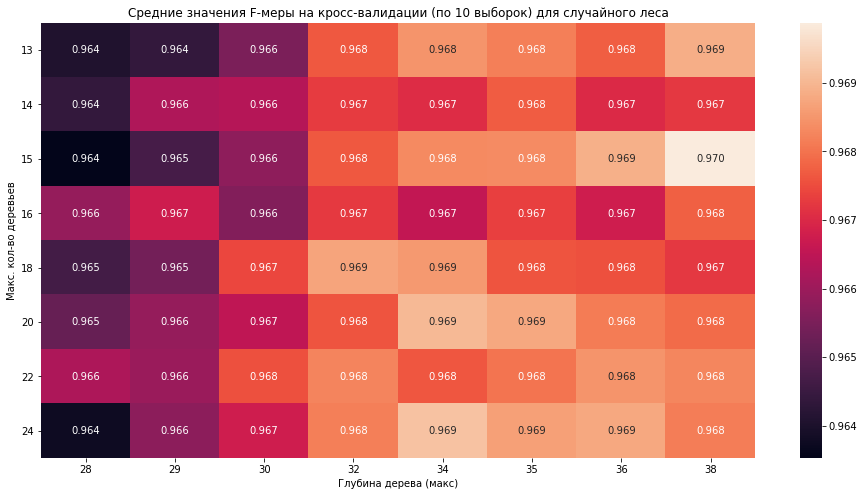

In [6]:
fig = plt.figure(figsize = (16,8))

ax = sns.heatmap(rand_for_res_mea, annot=rand_for_res_mea, fmt=".3f")
ax.set_xticklabels(mas_depth)
ax.set_yticklabels(mas_trees, rotation=0)
ax.set_title('Средние значения F-меры на кросс-валидации (по 10 выборок) для случайного леса')
ax.set_xlabel('Глубина дерева (макс)')
ax.set_ylabel('Макс. кол-во деревьев')

Дальнейшего улучшения не происходит, поэтому будем иметь в виду случайный лес с 15 деревьями максимальной глубины 38

## 4.3. Создание нейронных сетей (MLP); обучение с помощью кросс-валидации

Рассмотрим перцептроны (MLP) с кол-вом скрытых слоев от 2 до 4 (от 4 до 6 всех слоев), по 3 НС на каждое кол-во скрытых слоев. Будем варьировать размеры скрытых слоев, функция активации скрытого слоя - ReLU, кол-во эпох ограничим 200.

In [7]:
MLP_archs = [#пока возьмем 3 архитектуры
    [16,4],
    [16,8],
    [16,16],
    '''[32,4],
    [32,8],
    [32,16],
    [32,32],
    [48,4],
    [48,12],
    [48,24],
    [16,8,4],
    [16,8,8],
    [16,16,4],
    [16,16,8],
    [16,16,16],
    [32,8,4],
    [32,8,8],
    [32,16,4],
    [32,16,8],
    [32,16,16],
    [24,16,8,4],
    [24,16,8,8],
    [24,16,16,4],
    [24,16,16,8],
    [24,16,16,12],
    [24,16,16,16],
    [24,24,8,4],
    [24,24,8,8],
    [24,24,16,4],
    [24,24,16,8],'''
]

MLP_res_mea = [] #средние значения F1
MLP_res = []
MLP_roc_auc = []
MLP_prec_rec = []
MLP_mdls = []

In [8]:
i=1

for arch in MLP_archs:
    res_prom = [] #промежуточные оценки F1-score
    res_roc_auc = [] #значения roc-auc кривых
    res_prec_rec = [] #значения кривых precision-recall
    res_mdls = [] #модели
    
    print('Модель {}: обучение...'.format(i),end='')
    
    for k in range(10): #ручная кросс-валидация
        X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
        model = MLPClassifier(hidden_layer_sizes=tuple(arch), activation='relu', max_iter=200)
        model.fit(X_v1_train,y_v1_train)
            
        y_pred = model.predict_proba(X_v1_test)
        y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
        res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
        res_roc_auc.append(roc_curve(y_v1_test,y_pred))
        res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
        res_mdls.append(model)
            
    res_prom = np.array(res_prom,dtype=np.float32)
    MLP_res.append(res_prom)
    MLP_res_mea.append(res_prom.mean())
        
    MLP_roc_auc.append(res_roc_auc)
    MLP_prec_rec.append(res_prec_rec)
    MLP_mdls.append(res_mdls)
    
    print(' обучена')
    i+=1

Модель 1: обучение... обучена
Модель 2: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 обучена
Модель 3: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\skle

 обучена
Модель 4: обучение...

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'int'

In [9]:
MLP_res_mea

[0.8668539, 0.8668159, 0.8688837]

Результаты на уровне моделей линейной регрессии. Увеличим кол-во скрытых слоев:

In [10]:
MLP_archs = [
    [16,8,4],
    [16,16,4],
    [32,16,4]
]

MLP_res_mea = [] #средние значения F1
MLP_res = []
MLP_roc_auc = []
MLP_prec_rec = []
MLP_mdls = []

In [11]:
i=1

for arch in MLP_archs:
    res_prom = [] #промежуточные оценки F1-score
    res_roc_auc = [] #значения roc-auc кривых
    res_prec_rec = [] #значения кривых precision-recall
    res_mdls = [] #модели
    
    print('Модель {}: обучение...'.format(i),end='')
    
    for k in range(10): #ручная кросс-валидация
        X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
        model = MLPClassifier(hidden_layer_sizes=tuple(arch), activation='relu', max_iter=200)
        model.fit(X_v1_train,y_v1_train)
            
        y_pred = model.predict_proba(X_v1_test)
        y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
        res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
        res_roc_auc.append(roc_curve(y_v1_test,y_pred))
        res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
        res_mdls.append(model)
            
    res_prom = np.array(res_prom,dtype=np.float32)
    MLP_res.append(res_prom)
    MLP_res_mea.append(res_prom.mean())
        
    MLP_roc_auc.append(res_roc_auc)
    MLP_prec_rec.append(res_prec_rec)
    MLP_mdls.append(res_mdls)
    
    print(' обучена')
    i+=1

Модель 1: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 обучена
Модель 2: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 обучена
Модель 3: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\skle

 обучена


In [12]:
MLP_res_mea

[0.8703272, 0.869242, 0.8710042]

Результаты не улучшились. Пробуем еще 3 6-слойные НС и выбираем наилучшую модель из всех имеющихся

In [13]:
MLP_archs = [
    [24,16,8,4],
    [24,16,8,8],
    [24,16,16,4]
]

MLP_res_mea = [] #средние значения F1
MLP_res = []
MLP_roc_auc = []
MLP_prec_rec = []
MLP_mdls = []

In [14]:
i=1

for arch in MLP_archs:
    res_prom = [] #промежуточные оценки F1-score
    res_roc_auc = [] #значения roc-auc кривых
    res_prec_rec = [] #значения кривых precision-recall
    res_mdls = [] #модели
    
    print('Модель {}: обучение...'.format(i),end='')
    
    for k in range(10): #ручная кросс-валидация
        X_v1_train, X_v1_test, y_v1_train, y_v1_test = train_test_split(X_v1, y_v1, test_size=0.15)
            
        model = MLPClassifier(hidden_layer_sizes=tuple(arch), activation='relu', max_iter=200)
        model.fit(X_v1_train,y_v1_train)
            
        y_pred = model.predict_proba(X_v1_test)
        y_pred = (y_pred[:,1] >= 0.5).astype(dtype=np.uint8) #условно считаем порог равным 0.5
        res_prom.append(f1_score(y_v1_test,y_pred,average='macro'))
            
        res_roc_auc.append(roc_curve(y_v1_test,y_pred))
        res_prec_rec.append(precision_recall_curve(y_v1_test,y_pred))
        res_mdls.append(model)
            
    res_prom = np.array(res_prom,dtype=np.float32)
    MLP_res.append(res_prom)
    MLP_res_mea.append(res_prom.mean())
        
    MLP_roc_auc.append(res_roc_auc)
    MLP_prec_rec.append(res_prec_rec)
    MLP_mdls.append(res_mdls)
    
    print(' обучена')
    i+=1

Модель 1: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 обучена
Модель 2: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 обучена
Модель 3: обучение...

C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\a_bredihin\Anaconda3\lib\site-packages\skle

 обучена


In [15]:
MLP_res_mea

[0.87192076, 0.87339985, 0.87635756]

С ростом кол-ва скрытых слоев в MLP возросли значения F-меры.

Значения F-меры не дотягивают до лучшей из моделей случайного леса. Поэтому глубокие НС сейчас обучать не будем - завершаем процесс обучения, выбираем лучшую из моделей случайного леса и начинаем компоновать модель в формате pickle для полной обработки входных данных:

In [17]:
best_F = rand_for_res[2][7]
best_F

array([0.9705751 , 0.9717767 , 0.9693512 , 0.9689607 , 0.9706848 ,
       0.96966547, 0.96771216, 0.96976393, 0.97063184, 0.9696428 ],
      dtype=float32)

Выбираем модель под индексом 1 и строим графики показателей ее обучения:

Text(0, 0.5, 'Точность')

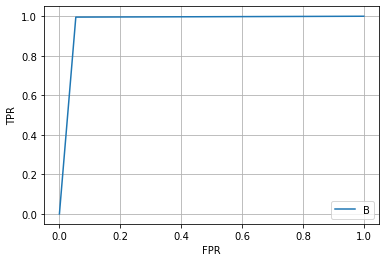

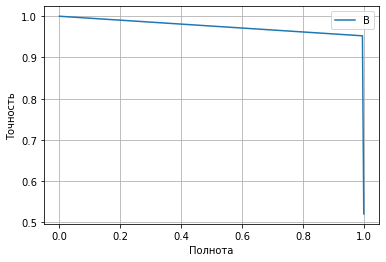

In [19]:
best_model = rand_for_mdls[2][7][1]
best_model_roc_auc = rand_for_roc_auc[2][7][1]
best_model_prec_rec = rand_for_prec_rec[2][7][1]

#чертим графики ROC-AUC и PR-кривых
plt.figure()
plt.plot(best_model_roc_auc[0],best_model_roc_auc[1])
plt.legend('Выборка версии 1')
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.figure()
plt.plot(best_model_prec_rec[1],best_model_prec_rec[0])
plt.legend('Выборка версии 1')
plt.grid()
plt.xlabel('Полнота')
plt.ylabel('Точность')

In [20]:
best_model

RandomForestClassifier(max_depth=38, n_estimators=15)

## 4.4. Компоновка pickle-модели

Pickle-модель будет состоять из следующих частей:
1. Пайплайн для отбора необходимых полей (переработанный с учетом наиболее значимых признаков);
2. Модуль выполнения left join;
3. Обученная ранее модель случайного леса

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#создаем класс выбора столбцов pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [22]:
#сверим поля, полученные на этапе 1, и полученные на этапе 3 top-10 признаков:

with open('cls.dat','rb') as f:
    f_ok = dill.load(f)

f_binary = f_ok[0]
f_categorical = f_ok[1]
f_numeric = f_ok[2]
f_ok = f_ok[0] + f_ok[1] + f_ok[2]

print(f_binary)
print(f_categorical)
print(f_numeric)

['252']
[]
['25', '80', '14', '50', '27', '158', '178', '183', '175', '1', '141', '74', '219', '124', '133', '151', '37', '68', '16', '60', '251', '47', '97', '46', '174', '91', '32', '109', '132', '137', '146', '243', '232', '34', '7', '69', '140', '138', '161', '208', '226', '238', '20', '239', '87', '35', '9', '52', '235', '162', '181', '78', '59', '18', '22', '213', '55', '215', '12', '13', '197', '207', '244', '58', '157', '88', '231', '245', '29', '93', '2', '152', '184', '228', '49', '164', '108', '236', '77', '117', '221', '103', '131', '135', '190', '79', '63', '94', '61', '66', '220', '230', '196', '19', '114', '127', '241', '71', '229', '167', '23', '96', '100', '41', '177', '150', '26', '64', '147', '206', '188', '176', '122', '145', '83', '123', '21', '104', '246', '105', '65', '84', '45', '101', '11', '211', '8', '125', '0', '202', '128', '86', '40', '116', '121', '38', '227', '106', '76', '144', '149', '165', '92', '24', '98', '180', '187', '160', '110', '113', '153', '4

In [23]:
f_top_10

[6.0, 4.0, 9.0, '59', '221', '123', '37', '26', '194', '80']

In [26]:
#В top-10 бинарных и категориальных признаков нет, т.е. все изначальные признаки - вещественные (за исключением dummy-признаков
#тарифа 6.0, 4.0, 9.0). НАйдем пересечение признаков из top-10 и изначальных признаков из data_train.csv и убедимся в этом:

f_fin_sel = list(set(f_top_10[3:]) & set(f_numeric))
f_fin_sel

['221', '26', '59', '194', '123', '37', '80']

In [27]:
#Но порядок столбцов не должен нарушаться! Поэтому возьмем для отбора названия столбцов из f_top_10:
f_fin_sel = f_top_10[3:]
f_fin_sel

['59', '221', '123', '37', '26', '194', '80']

In [30]:
#А теперь строим pipeline для отбора признаков из features:

#создаем pipeline
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_fin_sel),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_fin_sel),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        ))
    ])
)
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['59', '221', '123', '37', '26', '194', '80'])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['59',
                                                                           '221',
                                                                           '123',
                                                                           '37',
                                                                           '26',
                                                                           '194',
                                                                           '80'])),
                                                  ('simpleimputer',
                                                   SimpleImputer()),
                                                  ('sta

In [31]:
#сохраним наши части модели в pickle:
model_parts = (f_prep_pipeline, f_top_10, best_model)

with open('model_parts.dat','wb') as f:
    dill.dump(model_parts,f)